In [217]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

In [219]:
# Use pd.read_csv() to read the CSV file into a DataFrame.
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data = train_data.set_index('Id')
test_data = test_data.set_index('Id')

train_data['Response'] = train_data['Response']-1

In [220]:
# Visualize the top elements of features
train_data.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
Id,,,,,,,,,,,,,,,,,,,,,
2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,...,0,0,0,0,0,0,0,0,0,7
5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,...,0,0,0,0,0,0,0,0,0,3
6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,...,0,0,0,0,0,0,0,0,0,7
7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,...,0,0,0,0,0,0,0,0,0,7
8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,...,0,0,0,0,0,0,0,0,0,7


In [221]:
nulls = train_data.isnull().sum()
train_data.keys()


Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=127)

# 1: EDA

In [222]:
# Identify the datatype we are dealing with
train_data.dtypes

Product_Info_1          int64
Product_Info_2         object
Product_Info_3          int64
Product_Info_4        float64
Product_Info_5          int64
                       ...   
Medical_Keyword_45      int64
Medical_Keyword_46      int64
Medical_Keyword_47      int64
Medical_Keyword_48      int64
Response                int64
Length: 127, dtype: object

[8 4 1 6 2 7 3 5]


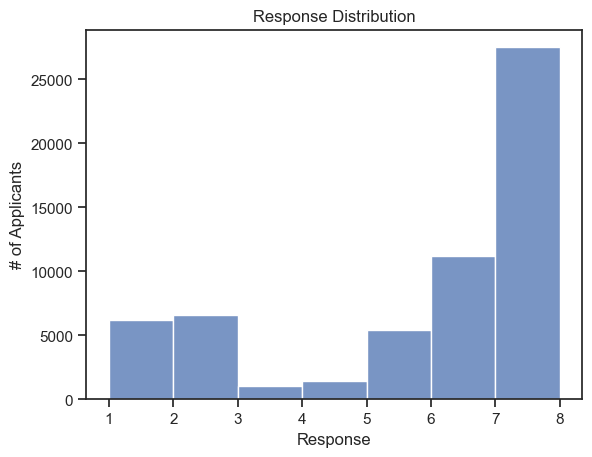

In [183]:
# Visualise the distribution of applicants' risk ratings in the full dataset.
sns.histplot(train_data['Response'], bins=sorted(train_data['Response'].unique()))
plt.xlabel('Response')
plt.ylabel('# of Applicants')
plt.title('Response Distribution')

print(train_data['Response'].unique())

| Variable             | Description                                                                                      |
|----------------------|--------------------------------------------------------------------------------------------------|
| Id                   | A unique identifier associated with an application.                                               |
| Product_Info_1-7     | A set of normalized variables relating to the product applied for.                                |
| Ins_Age              | Normalized age of the applicant.                                                                 |
| Ht                   | Normalized height of the applicant.                                                              |
| Wt                   | Normalized weight of the applicant.                                                              |
| BMI                  | Normalized BMI of the applicant.                                                                 |
| Employment_Info_1-6  | A set of normalized variables relating to the employment history of the applicant.               |
| InsuredInfo_1-6      | A set of normalized variables providing information about the applicant.                            |
| Insurance_History_1-9| A set of normalized variables relating to the insurance history of the applicant.                 |
| Family_Hist_1-5      | A set of normalized variables relating to the family history of the applicant.                    |
| Medical_History_1-41 | A set of normalized variables relating to the medical history of the applicant.                   |
| Medical_Keyword_1-48 | A set of dummy variables relating to the presence/absence of a medical keyword associated with the application. |
| Response             | This is the target variable, an ordinal variable relating to the final decision associated with an application. |


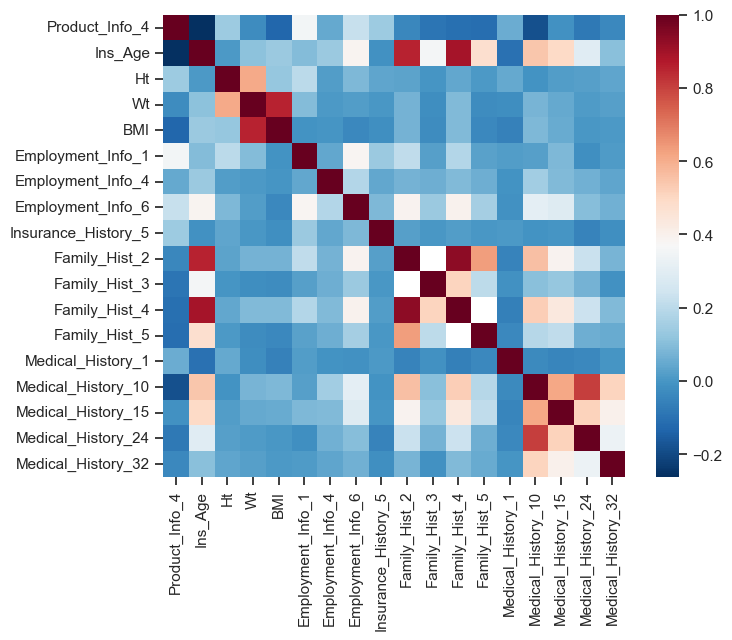

In [223]:
# Select only the columns with floating-point data (float64)
float_columns = train_data.select_dtypes(include=['float64'])

# Create a scatterplot matrix using Seaborn
sns.set(style="ticks")

# Calculate the correlation matrix
correlation_matrix = train_data[float_columns.columns].corr()
mask = np.zeros_like(correlation_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', fmt=".2f", square=True)

# sns.pairplot(X_train[float_columns.columns], kind="scatter", diag_kind="kde")

# Show the plot
plt.show()

### 1. Split into train, test, valid datasets

In [224]:
# Assign the features to their own dataframe.
X = train_data.drop(['Response'], axis=1)

# Assign the target variable to its own dataframe.
y = train_data['Response']
# Perform a train-test split to obtain the training, validation and test data as separate dataframes.
from sklearn.model_selection import train_test_split

# Split out test/holdout set from full dataset.
# We will set the size of the X/y test datasets to be 20% of the original (full) X/y datasets, via the train_size/test_size parameters.
X_rem, X_test, y_rem, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)

# Split remaining portion into training/validation sets.
# We will set the size of the X/y train datasets to be 60% of the original (full) X/y datasets, via the train_size/test_size parameters.
X_train, X_valid, y_train, y_valid = train_test_split(X_rem, y_rem, train_size=0.75, test_size=0.25, random_state=0, stratify=y_rem)

### 2. Handle missing values 

In [225]:
# Determine which columns contain nulls/missing values.
X_train_cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Summarise how many missing values are present in each column.
X_train[X_train_cols_with_missing].isna().sum()

Employment_Info_1         16
Employment_Info_4       4002
Employment_Info_6       6518
Insurance_History_5    15196
Family_Hist_2          17141
Family_Hist_3          20591
Family_Hist_4          11458
Family_Hist_5          25107
Medical_History_1       5368
Medical_History_10     35299
Medical_History_15     26744
Medical_History_24     33312
Medical_History_32     34980
dtype: int64

In [206]:
# Calculate the proportion of zeroes relative to non-zero values.
for col in X_train_cols_with_missing:
    sum = X_train[col].isna().sum()
    length = len(X_train[col].index)
    ratio = sum/length
    print('Proportion of zeroes in', col, 'is: ', round(ratio*100,2), '%.')

Proportion of zeroes in Employment_Info_1 is:  0.04 %.
Proportion of zeroes in Employment_Info_4 is:  11.23 %.
Proportion of zeroes in Employment_Info_6 is:  18.29 %.
Proportion of zeroes in Insurance_History_5 is:  42.65 %.
Proportion of zeroes in Family_Hist_2 is:  48.11 %.
Proportion of zeroes in Family_Hist_3 is:  57.79 %.
Proportion of zeroes in Family_Hist_4 is:  32.16 %.
Proportion of zeroes in Family_Hist_5 is:  70.47 %.
Proportion of zeroes in Medical_History_1 is:  15.07 %.
Proportion of zeroes in Medical_History_10 is:  99.08 %.
Proportion of zeroes in Medical_History_15 is:  75.06 %.
Proportion of zeroes in Medical_History_24 is:  93.5 %.
Proportion of zeroes in Medical_History_32 is:  98.18 %.


In [226]:
# These columns have been selected as they contain a high proportion of blanks/missing values (deemed here as >40%) in the TRAINING dataset.
cols_to_delete_due_to_missing_data = [ 'Family_Hist_3', 'Family_Hist_5',
                                      'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']

# Delete columns from ALL datasets where the proportion of zeroes in the TRAINING dataset exceeds a stipulated threshold.
X_train = X_train.drop(cols_to_delete_due_to_missing_data, axis=1)
X_valid = X_valid.drop(cols_to_delete_due_to_missing_data, axis=1)
X_test = X_test.drop(cols_to_delete_due_to_missing_data, axis=1)

In [189]:
# Impute missing values
cols_to_fill = ['Employment_Info_1','Employment_Info_4','Employment_Info_6','Insurance_History_5',
                'Family_Hist_2', 'Family_Hist_4','Medical_History_1']
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
X_test_copy = X_test.copy()

# Fill the null elements with median values
X_train_copy.fillna(X_train[cols_to_fill].median(), inplace=True)
X_valid_copy.fillna(X_valid[cols_to_fill].median(), inplace=True)
X_test_copy.fillna(X_test[cols_to_fill].median(), inplace=True)


X_train_copy

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
Id,,,,,,,,,,,,,,,,,,,,,
55970,1,E1,26,0.076923,2,3,1,0.417910,0.690909,0.267782,...,0,0,0,0,0,0,0,0,0,0
62728,1,A8,26,0.076923,2,1,1,0.462687,0.618182,0.236402,...,0,0,0,0,0,0,0,0,0,0
43208,1,D3,26,0.076923,2,3,1,0.432836,0.800000,0.387029,...,0,0,0,0,0,0,0,0,0,0
802,1,D3,26,0.128205,2,3,1,0.626866,0.600000,0.188285,...,0,0,0,0,0,0,0,0,0,0
27509,1,D1,26,0.128205,2,3,3,0.656716,0.781818,0.353556,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,1,A5,26,0.487179,2,1,1,0.208955,0.763636,0.288703,...,0,0,0,0,0,0,0,0,0,0
65810,1,D2,26,0.230769,2,3,1,0.597015,0.818182,0.456067,...,0,0,0,0,0,0,0,0,0,0
28142,1,D4,26,0.230769,2,3,1,0.298507,0.618182,0.163180,...,0,0,0,0,0,0,0,0,0,0


### 3. Handle categorical columns with one-hot encoding

In [227]:
# String columns
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

one_hot_encoded_train = encoder.fit_transform(X_train_copy[['Product_Info_2']])
# Create a new DataFrame with one-hot encoded data
one_hot_train = pd.DataFrame(one_hot_encoded_train, columns=encoder.get_feature_names_out(['Product_Info_2']))
one_hot_encoded_test = encoder.fit_transform(X_test_copy[['Product_Info_2']])
# Create a new DataFrame with one-hot encoded data
one_hot_test = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(['Product_Info_2']))
one_hot_encoded_valid = encoder.fit_transform(X_valid_copy[['Product_Info_2']])
# Create a new DataFrame with one-hot encoded data
one_hot_valid = pd.DataFrame(one_hot_encoded_valid, columns=encoder.get_feature_names_out(['Product_Info_2']))

# Reset indexes
X_train_copy = X_train_copy.reset_index(drop=True)
one_hot_train = one_hot_train.reset_index(drop=True)
X_test_copy = X_test_copy.reset_index(drop=True)
one_hot_test = one_hot_test.reset_index(drop=True)
X_valid_copy = X_valid_copy.reset_index(drop=True)
one_hot_valid = one_hot_valid.reset_index(drop=True)


# Concatenate the new DataFrame with the original D"ataFrame
X_train_enc = pd.concat([X_train_copy, one_hot_train], axis=1)
X_train_enc = X_train_enc.drop('Product_Info_2',axis=1)
X_test_enc = pd.concat([X_test_copy, one_hot_test], axis=1)
X_test_enc = X_test_enc.drop('Product_Info_2',axis=1)
X_valid_enc = pd.concat([X_valid_copy, one_hot_valid], axis=1)
X_valid_enc = X_valid_enc.drop('Product_Info_2',axis=1)


print(X_train_enc)

       Product_Info_1  Product_Info_3  Product_Info_4  Product_Info_5  \
0                   1              26        0.076923               2   
1                   1              26        0.076923               2   
2                   1              26        0.076923               2   
3                   1              26        0.128205               2   
4                   1              26        0.128205               2   
...               ...             ...             ...             ...   
35623               1              26        0.487179               2   
35624               1              26        0.230769               2   
35625               1              26        0.230769               2   
35626               1              26        0.025641               2   
35627               1              26        0.076923               2   

       Product_Info_6  Product_Info_7   Ins_Age        Ht        Wt       BMI  \
0                   3               1  0.4

### 4. Rescale data
- We rescale the all values in the data between 0 to 1.

In [209]:
# Rescale variables
from sklearn.preprocessing import MinMaxScaler  #rescale data
scaler = MinMaxScaler()
# Fit
scaler.fit(X_train_enc)
# Replace the original float columns with the scaled values
X_train_scale = pd.DataFrame(scaler.transform(X_train_enc),
                             index=X_train_enc.index,
                             columns=X_train_enc.columns)

X_valid_scale = pd.DataFrame(scaler.transform(X_valid_enc),
                             index=X_valid_enc.index,
                             columns=X_valid_enc.columns)

X_test_scale = pd.DataFrame(scaler.transform(X_test_enc),
                             index=X_test_enc.index,
                             columns=X_test_enc.columns)

### 5. K-Means clustering

We perform K-Means clustering to find new features or patterns in the data.

In [228]:
# Create copies of the scaled datasets, prior to performing K-Means clustering.
copy_X_train_scale = X_train_scale.copy()
copy_X_valid_scale = X_valid_scale.copy()
copy_X_test_scale = X_test_scale.copy()

if copy_X_train_scale.isna().any().any():
    print("There are NaN values in the DataFrame.")
    
nan_columns = copy_X_train_scale.columns[copy_X_train_scale.isna().any()].tolist()
print(nan_columns)

[]


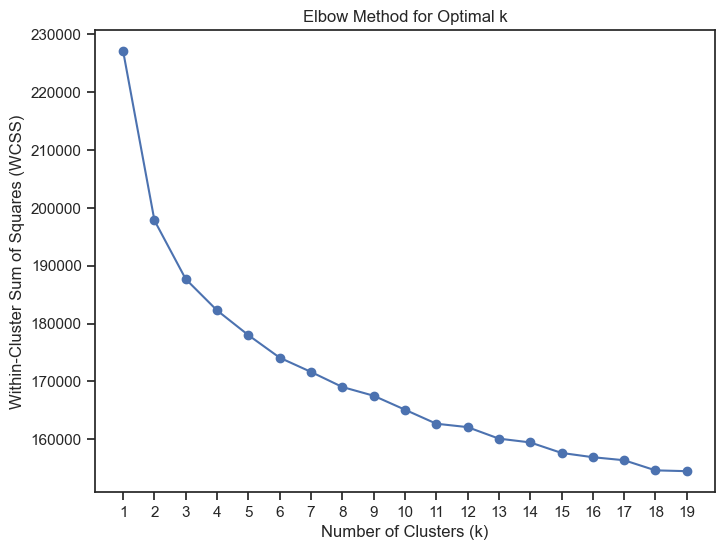

In [193]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters.
# Method: Cluster the dataset into k clusters, then calculate the inertia/sum of squared distances.
# Repeat this by looping through k=1 to k=30.
wcss = []
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(copy_X_train_scale)
    wcss.append(km.inertia_)
    
# Plot the WCSS values against the number of clusters (k)
plt.figure(figsize=(8, 6))
plt.plot(K, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K)
plt.show()

### 6. Mutual information

This gives us a way of making sure to preserve features for final model training.

d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataC

Top 19 features based on Mutual Information:
['BMI', 'Wt', 'Medical_History_23', 'Medical_History_4', 'Product_Info_4', 'Medical_Keyword_15', 'Medical_Keyword_3', 'Ins_Age', 'Family_Hist_4', 'Family_Hist_2', 'Medical_History_39', 'Medical_History_2', 'Product_Info_2_A7', 'InsuredInfo_6', 'Medical_Keyword_23', 'Ht', 'Medical_History_6', 'Product_Info_2_D4', 'Employment_Info_2']


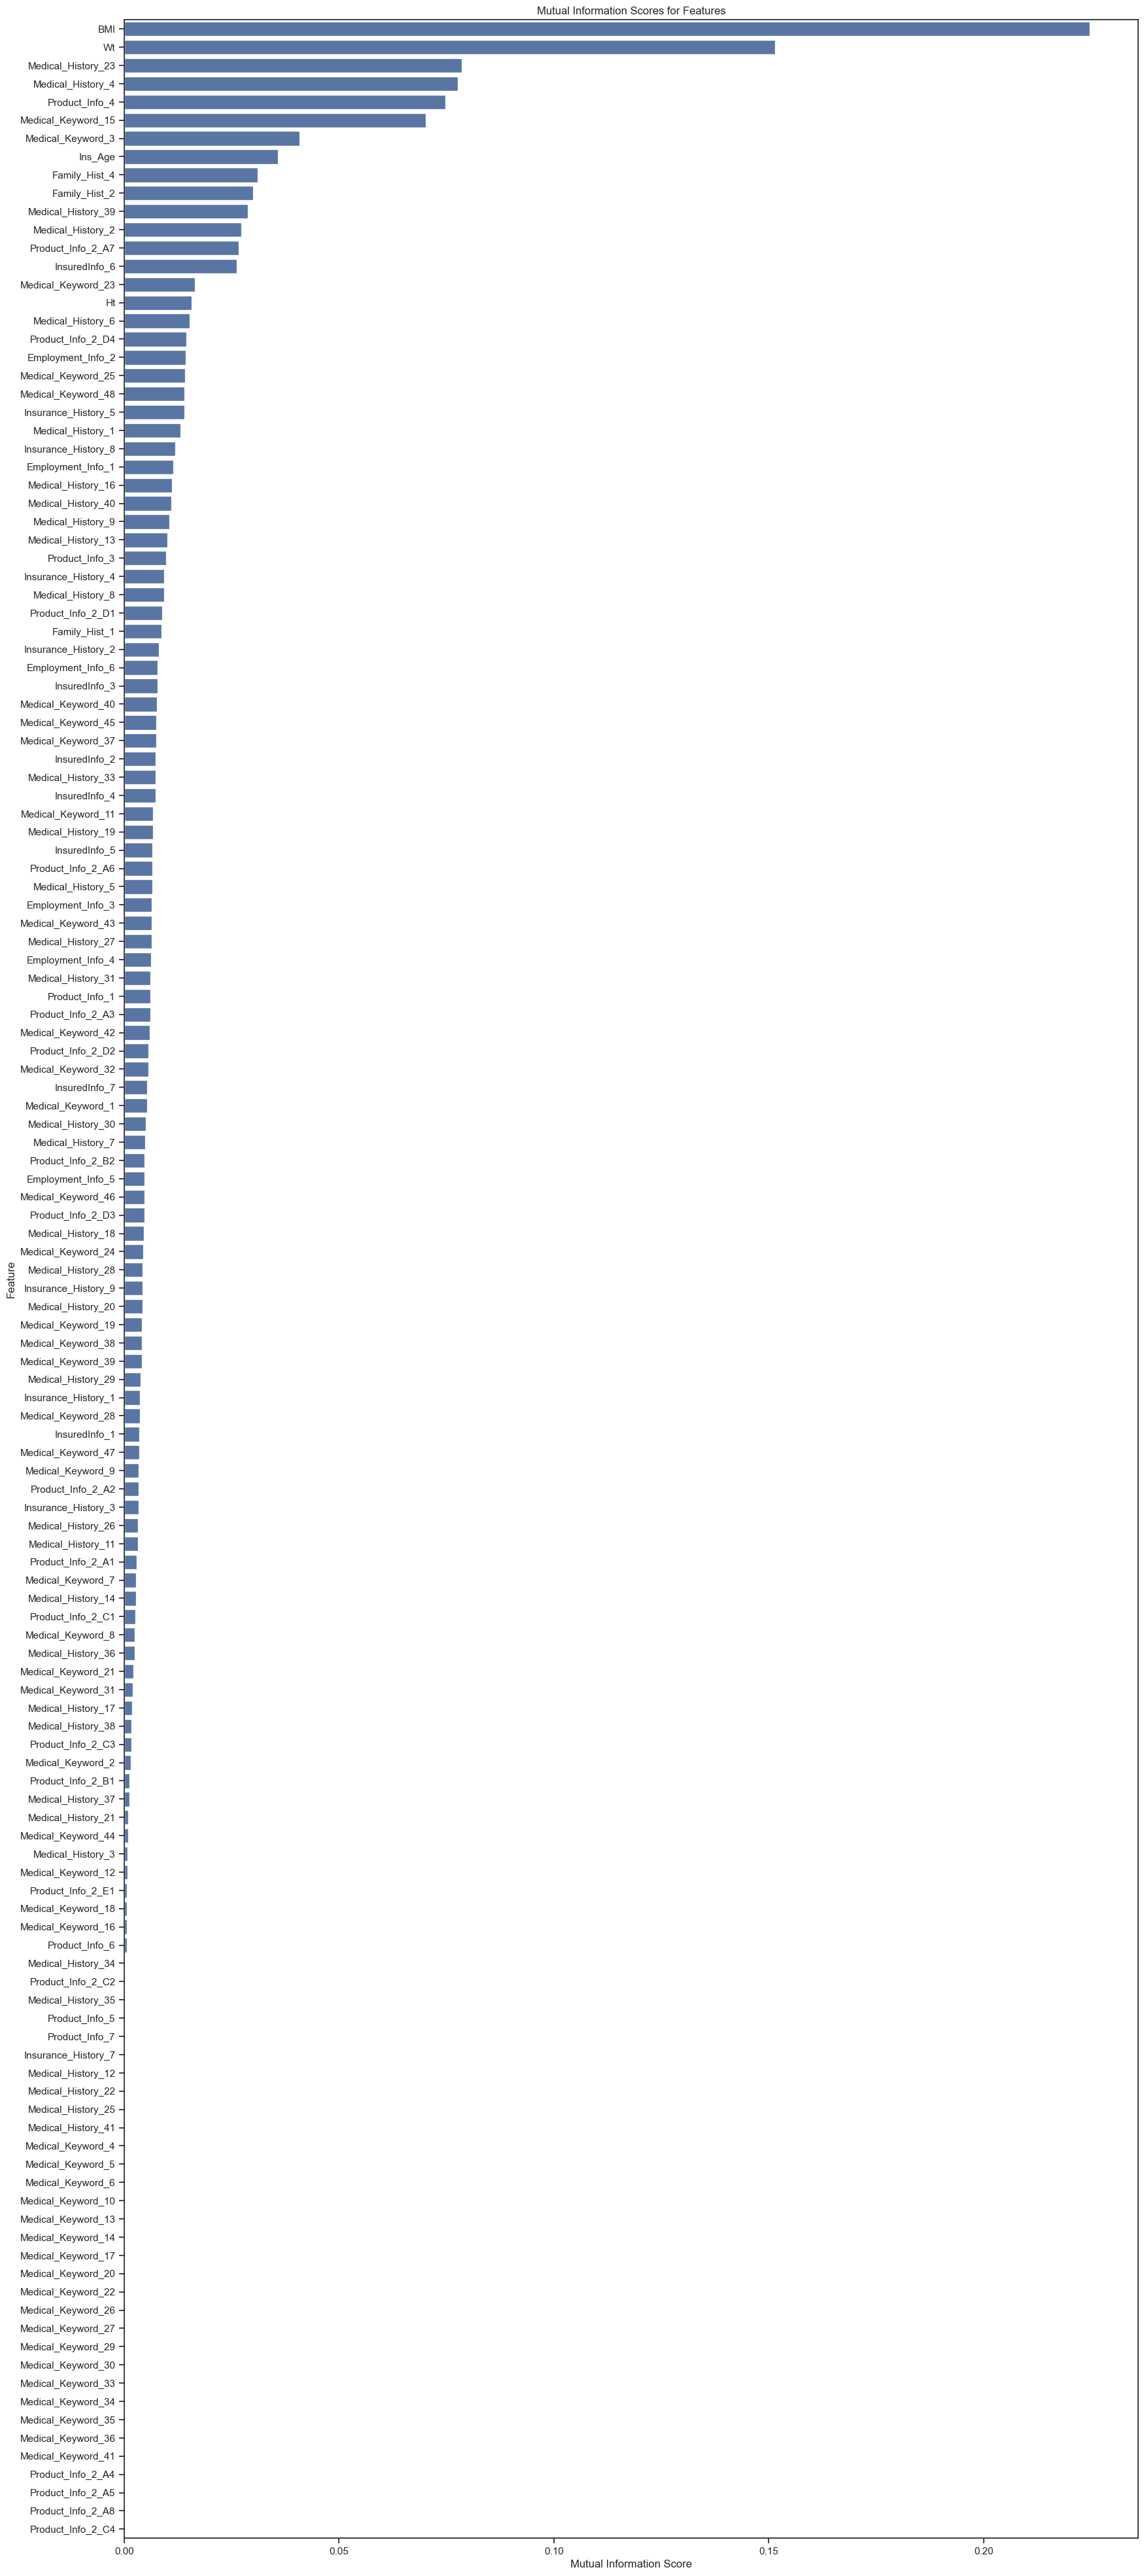

In [194]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # For classification tasks

y_train
# Initialize an empty list to store selected feature names
selected_features = []
# Loop through all columns (excluding the target variable)
for col in X_train_scale:
    # Select the current feature and the target variable
    X = X_train_scale[[col]]
    
    # Compute Mutual Information for the current feature and target variable
    mi_score = mutual_info_classif(X, y_train)[0]  # For classification tasks
    # OR
    # mi_score = mutual_info_regression(X, target)[0]  # For regression tasks
    
    # Store the feature name and its MI score
    selected_features.append((col, mi_score))

# Sort the features by MI score in descending order
selected_features.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame from the list for plotting
mi_df = pd.DataFrame(selected_features, columns=['Feature', 'MI Score'])

# Get the top k features based on MI score
top_k_features = [feature[0] for feature in selected_features[:k]]

print("Top", k, "features based on Mutual Information:")
print(top_k_features)

# Create a sideways barplot
plt.figure(figsize=(20, 50))
sns.barplot(x='MI Score', y='Feature', data=mi_df, orient='h')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Features')
plt.show()

# 2: Create classifier model

In [237]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_scale, label=y_train)
dtest = xgb.DMatrix(X_test_scale)

# Define XGBoost parameters for multi-class classification
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 8,               # Number of classes in the target variable
    'max_depth': 3,               # Maximum tree depth
    'eta': 0.3,                   # Learning rate
    'eval_metric': 'merror'     # Evaluation metric for multi-class classification
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

Accuracy: 54.43%


### Peformance metrics

d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
d:\GitHub\prudential_life_insurance_data_analysis\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

Accuracy: 0.5398282249915797
Precision: 0.44410851141589497
Recall: 0.3652338203934503
F1 Score: 0.3792026697767114
Confusion Matrix:
 [[ 317  189    7   16   87  262  101  263]
 [ 147  344    9   15  166  285   93  251]
 [  13   20   11    8   55   77    4   14]
 [   7    3    1   28    1  139   12   95]
 [  37   92    8    0  540  258   42  110]
 [ 103   83    1   16   84 1190  263  506]
 [  47   11    0    9    7  355  556  620]
 [  19   11    0   25    4  281  133 3425]]


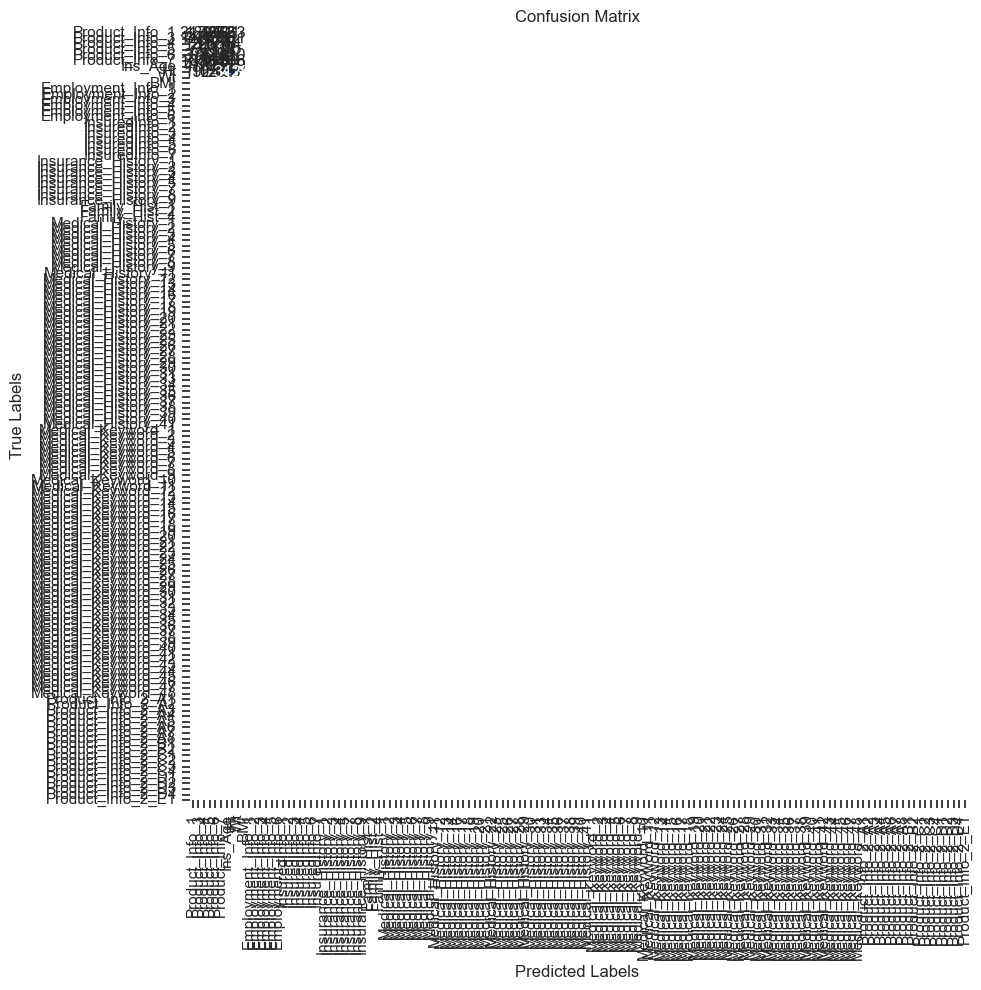

In [250]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
dtest = xgb.DMatrix(X_valid_scale)
# Make predictions on the validation dataset
y_pred = model.predict(dtest)

# Compute accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_valid, y_pred, average='macro')  # You can also use 'micro', 'weighted', or None
print("Precision:", precision)

# Compute recall
recall = recall_score(y_valid, y_pred, average='macro')  # You can also use 'micro', 'weighted', or None
print("Recall:", recall)

# Compute F1 score
f1 = f1_score(y_valid, y_pred, average='macro')  # You can also use 'micro', 'weighted', or None
print("F1 Score:", f1)

# Compute confusion matrix
confusion = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", confusion)


# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=X_valid_scale.columns, yticklabels=X_valid_scale.columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [216]:
unique_labels = set(y_train)  # Assuming y_train is your target variable
print("Unique labels:", unique_labels)
np.sum(unique_labels)

Unique labels: {1, 2, 3, 4, 5, 6, 7, 8}


{1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
a = pd.DataFrame(y_train)
a.nunique()

Response    8
dtype: int64

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(D,)),  # Specify input dimension
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')  # 8 output units for 8 classes
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
target.dtype